In [1]:
import os
os.chdir('..')

# Import Files

In [2]:
from tqdm import tqdm

In [3]:
from src.agent_interface import *
from src.agent import *
from src.env import *
from src.price_data import *
from src.prior_measure import *
from src.q import *
from src.robust import *
from src.util import *

# Initialize Environment

In [4]:
start_date = '1995-01-01'
end_date = '2024-12-31'
batch_size = 128

stock_params = {
    'symbol': 'SPY',
    'start_date': start_date,
    'end_date': end_date
}

env_params = {
    'start_date': start_date,
    'end_date': end_date,
    'rf_rate': 0.024,
    'trans_cost': 0.005,
    'batch_size': batch_size,
    'logging': True,
    'seed': 42
}

In [5]:
yf = YahooFinance(**stock_params)
df = yf.pipeline()
asset_log_returns = df['log_return'].dropna().to_numpy()
env = PortfolioEnv(asset_log_returns=asset_log_returns, **env_params)

[*********************100%***********************]  1 of 1 completed


# Initialize Agent

In [6]:
device = torch.device("cuda")

#Shared params
n_updates = 1
state_dim = 63
action_dim = 1

training_controller_params = {
    'train_steps': 1,
    'clone_steps': 50,
    'batch_size': batch_size,
    'n_batches': n_updates,
}

duality_params = {
    'discount_rate': 0.99,
    'delta': 1e-4,
    'sinkhorn_radius': 0.003,
}

q_params = {
    'input_size': state_dim,
    'hidden_size': [64, 64],
    'output_size': action_dim
}

dqn_params = {
    'state_dim': state_dim,
    'action_dim': action_dim,
    'batch_size': batch_size,
    'n_updates': n_updates,
    'epsilon': 0.1,
    "network_lr": 1e-4,
    'hq_lr': 0.02,
    'seed': 123
}

other_params = {
    "model_name": "TEST_MODEL",
    "n_epochs": 5
}

In [7]:
training_controller = TrainingController(**training_controller_params)
prior_measure = PriorStudentDistribution(device=device)
duality_operator = DualityHQOperator(**duality_params)
q = QFunc(**q_params)
writer = PORDQNProgressWriter(other_params['model_name'], overwrite_existing_file=True)
agent = PORDQN(training_controller=training_controller, prior_measure=prior_measure, duality_operator=duality_operator,
               qfunc = q, writer=writer, device=device, **dqn_params)

In [ ]:
config_path = f"./runs/{other_params['model_name']}/config.json"
params = {
    "stock_params": stock_params,
    "env_params": env_params, 
    "training_controller_params":training_controller_params,
    "duality_params": duality_params,
    "q_params": q_params,
    "dqn_params":dqn_params,
    "other_params": other_params
}
Config().download_config(params, config_path)

# Training

In [ ]:
for epoch in range(1 , other_params['n_epochs']+1):
    cum_rewards = np.zeros(shape=(batch_size, 1))
    observation, _ = env.reset()
    action_idx = agent.agent_start(observation)
    steps = env.action_steps
    done = np.array([False]*batch_size)
    
    with tqdm(total=steps, desc=f"Episode {epoch}", mininterval=2) as step_bar:
        while not done.any():
            next_state, reward, done, truncated, info = env.step(action_idx)
            cum_rewards += reward
            if done.any():
                agent.agent_end(reward=reward, observation=next_state, info=info)
            else:
                action_idx = agent.agent_step(reward=reward, observation=next_state, info=info)
            
            step_bar.update(1)
        
            if writer is not None:
                writer.save_model_params_periodically(epoch, agent, checkpoint_interval=1000)
    
    writer.save_latest_model_params(epoch, agent)
    writer.writer.flush()
    
    print(f'Episode {epoch} mean of summed rewards: {cum_rewards.mean():.3f}')

writer.close_writer()

Episode 5: 100%|██████████| 7492/7492 [08:05<00:00, 15.42it/s]


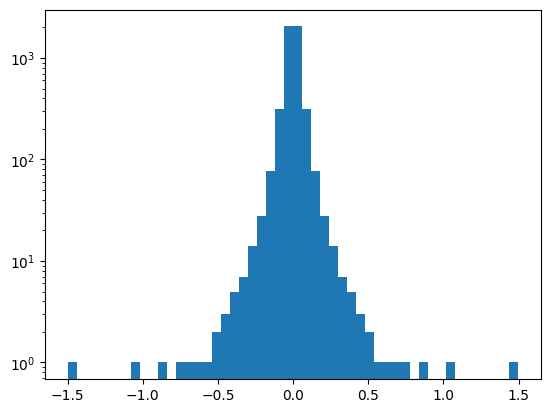

In [34]:
import matplotlib.pyplot as plt
plt.hist(prior_measure.support.cpu().numpy(), bins=50)
plt.yscale('log')
plt.show()

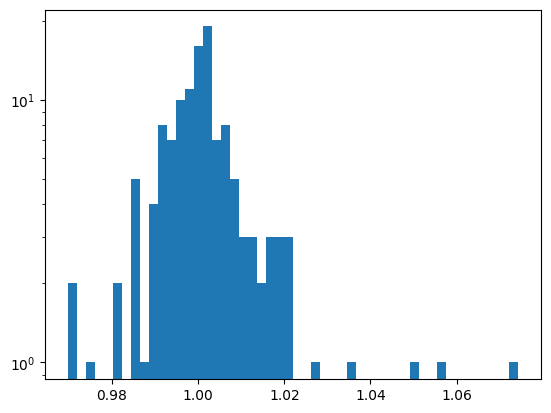

In [36]:
plt.hist(np.exp(reward), bins=50)
plt.yscale('log')
plt.show()